In [83]:
#requirements
# ! pip install xgboost scikit-learn

In [84]:
import sklearn
import numpy as np
import xgboost as xgb 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [85]:
# preprocessing steps from previous notebook
df = pd.read_excel("./Curated_data_1234_datapoints.xlsx")
df.columns = df.columns.str.strip()
df = df.drop(columns=["Reference DOI", "Unnamed: 23"], axis=1)
df['Support Loading [wt.%]'] = 100 - df['Metal Loading [wt.%]'] - df['Promoter 1 loading [wt.%]'] - df['Promoter 2 loading [wt.%]']

display(df)

,STY [mgMeOH h-1 gcat-1],Family,Metal Loading [wt.%],CR Metal [pm],Support 1,MW Support 1 [g mol-1],Name of Support2,MW of Support 2 [g mol-1],Name of Support 3,MW Support 3 [g mol-1],...,Promoter 2 loading [wt.%],Calcination Temperature [K],Calcination duration [h],SBET [m2 g-1],H2/CO2 [-],GHSV [cm3 h-1 gcat-1],Catalyst amount [g],Pressure [Mpa],Temperature [K],Support Loading [wt.%]
0,2620.0,In2O3,4.4,144,Fe3O4,159.69,0,0,0,0.0,...,0.2,623,2.0,9.0,10.0,115500.0,0.50,6.0,598.0,88.6
1,2400.0,In2O3,4.4,144,Fe3O4,159.69,0,0,0,0.0,...,0.2,623,2.0,9.0,8.0,94500.0,0.50,6.0,598.0,88.6
2,2233.6,Cu,36.5,138,ZnO,81.38,0,0,SBA-15,60.0,...,0.0,573,4.0,218.0,3.0,120000.0,0.02,4.0,453.0,60.8
3,2230.0,In2O3,4.4,144,Fe3O4,159.69,0,0,0,0.0,...,0.2,623,2.0,9.0,10.0,115500.0,0.50,4.0,598.0,88.6
4,2224.0,Cu,36.5,138,ZnO,81.38,SBA-15,60,0,0.0,...,0.0,773,5.0,218.0,3.0,60000.0,0.04,4.0,453.0,60.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1229,382.4,Cu,67.0,138,ZnO,81.38,Al2O3,101.96,0,0.0,...,0.0,623,3.0,96.0,4.0,24000.0,0.10,4.0,473.0,33.0
1230,887.2,Cu,67.0,138,ZnO,81.38,Al2O3,101.96,0,0.0,...,0.0,623,3.0,96.0,4.0,42000.0,0.10,4.0,493.0,33.0
1231,1119.0,Cu,67.0,138,ZnO,81.38,Al2O3,101.96,0,0.0,...,0.0,623,3.0,96.0,4.0,42000.0,0.10,4.0,513.0,33.0
1232,440.0,Cu,67.0,138,ZnO,81.38,Al2O3,101.96,0,0.0,...,0.0,623,3.0,96.0,3.0,24000.0,0.10,3.0,513.0,33.0


In [86]:
y = df.iloc[:, 0]
y = y/1000  #units aren't consistent

display(y)

0       2.6200
1       2.4000
2       2.2336
3       2.2300
4       2.2240
         ...  
1229    0.3824
1230    0.8872
1231    1.1190
1232    0.4400
1233    0.0310
Name: STY [mgMeOH h-1 gcat-1], Length: 1234, dtype: float64

In [87]:
X = df[["Metal Loading [wt.%]", "Support Loading [wt.%]", "Promoter 1 loading [wt.%]", "Promoter 2 loading [wt.%]", "SBET [m2 g-1]", "H2/CO2 [-]", "GHSV [cm3 h-1 gcat-1]", "Catalyst amount [g]", "Pressure [Mpa]", "Temperature [K]", "Calcination Temperature [K]", "Calcination duration [h]"]]

# rename the columns
column_names = ["M", "S", "PR1", "PR2", "S$_{BET}$", "H$_2$/CO$_2$", "GHSV", "MC", "P", "T", "CT", "CD"]
X.columns = column_names

display(X)

,M,S,PR1,PR2,S$_{BET}$,H$_2$/CO$_2$,GHSV,MC,P,T,CT,CD
0,4.4,88.6,6.8,0.2,9.0,10.0,115500.0,0.50,6.0,598.0,623,2.0
1,4.4,88.6,6.8,0.2,9.0,8.0,94500.0,0.50,6.0,598.0,623,2.0
2,36.5,60.8,2.7,0.0,218.0,3.0,120000.0,0.02,4.0,453.0,573,4.0
3,4.4,88.6,6.8,0.2,9.0,10.0,115500.0,0.50,4.0,598.0,623,2.0
4,36.5,60.8,2.7,0.0,218.0,3.0,60000.0,0.04,4.0,453.0,773,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1229,67.0,33.0,0.0,0.0,96.0,4.0,24000.0,0.10,4.0,473.0,623,3.0
1230,67.0,33.0,0.0,0.0,96.0,4.0,42000.0,0.10,4.0,493.0,623,3.0
1231,67.0,33.0,0.0,0.0,96.0,4.0,42000.0,0.10,4.0,513.0,623,3.0
1232,67.0,33.0,0.0,0.0,96.0,3.0,24000.0,0.10,3.0,513.0,623,3.0


In [88]:
#split into 85:15
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.15, random_state=10)

# do a KFold cross validation to check performance
kf = sklearn.model_selection.KFold(n_splits=5, shuffle=True, random_state=10)


scores = list()
for training, validation in kf.split(X_train):

    X_t, X_v = X_train.iloc[training], X_train.iloc[validation]
    y_t, y_v = y_train.iloc[training], y_train.iloc[validation]

    model = xgb.XGBRegressor(n_estimators=800,
                             learning_rate=0.20,
                             max_depth=8,
                             subsample=0.50,
                             colsample_bytree=0.50,
                             random_state=10
                             )
    model.fit(X_t, y_t)

    predictions = model.predict(X_v)
    score = sklearn.metrics.root_mean_squared_error(y_v, predictions)
    scores.append(score)


avg_score = np.mean(scores)

avg_score

np.float64(0.11407667756615902)

In [89]:
# train on full training data
model = xgb.XGBRegressor(n_estimators=800,
                         learning_rate=0.20,
                         max_depth=8,
                         subsample=0.50,
                         colsample_bytree=0.50,
                         random_state=10
                         )


model.fit(X_train, y_train)

y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)


#calculate metrics to plot
rmse = sklearn.metrics.root_mean_squared_error(y_test, y_pred_test)
r_squared_test = sklearn.metrics.r2_score(y_test, y_pred_test)
r_squared_train = sklearn.metrics.r2_score(y_train, y_pred_train)

print(rmse, r_squared_test, r_squared_train)

0.08906620530863456 0.8862897030955258 0.9981213295746721


In [90]:
# combine test and train predictions to use sns hue

plot_df_test = pd.DataFrame()
plot_df_test["Actual STY"] = y_test
plot_df_test["Predicted STY"] = y_pred_test
plot_df_test["type"] = "Test data"

plot_df_train = pd.DataFrame()
plot_df_train["Actual STY"] = y_train
plot_df_train["Predicted STY"] = y_pred_train
plot_df_train["type"] = "Training data"

plot_df = pd.concat([plot_df_test, plot_df_train])

display(plot_df)


,Actual STY,Predicted STY,type
123,0.370000,0.275549,Test data
693,0.061120,0.074015,Test data
924,0.024891,-0.013455,Test data
904,0.027875,0.068774,Test data
546,0.092575,0.100457,Test data
...,...,...,...
733,0.054771,0.054786,Training data
1180,0.264173,0.261606,Training data
1147,0.524000,0.516260,Training data
527,0.100335,0.100544,Training data


Text(0.5, 1.015, 'Model Prediction by Extreme Gradient Boost (XGB)')

<Figure size 640x480 with 0 Axes>

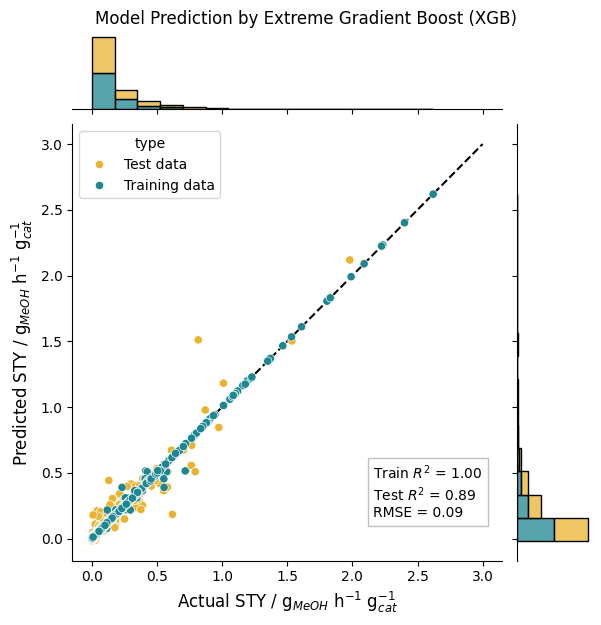

In [101]:
plt.figure()

cpalette = {"Training data": '#1e8691', "Test data":"#ebb22f"}

# using a JointGrid. jointplot forces a KDE with scatter, or heatmap with hist
ax = sns.JointGrid(plot_df, 
                x="Actual STY", 
                y="Predicted STY", 
                hue="type",
                palette=cpalette
                )


ax.plot_marginals(sns.histplot,
                  stat='density',
                  common_norm=False,
                  multiple="stack",
                  bins=15
                  )


ax.plot_joint(sns.scatterplot,
              )


# the diagonal
ax.ax_joint.plot([0, 3], [0, 3], 'k--', zorder=0)



stats_text = (f"Train $R^2$ = {r_squared_train:.2f}\n"
              f"Test $R^2$ = {r_squared_test:.2f}\n"
              f"RMSE = {rmse:.2f}")


ax.ax_joint.text(0.7, 0.1, stats_text, transform=ax.ax_joint.transAxes, 
                 fontsize=10, bbox=dict(facecolor='white', alpha=0.5, edgecolor='gray'))


ax.set_axis_labels('Actual STY / g$_{MeOH}$ h$^{-1}$ g$_{cat}^{-1}$', 
                  'Predicted STY / g$_{MeOH}$ h$^{-1}$ g$_{cat}^{-1}$', fontsize=12)


ax.fig.suptitle("Model Prediction by Extreme Gradient Boost (XGB)", y = 1.015)